#ShapleyVIC installation

In [1]:
! pip install git+"https://github.com/nliulab/ShapleyVIC#egg=ShapleyVIC&subdirectory=python"

  Cloning https://github.com/nliulab/ShapleyVIC to /tmp/pip-install-gwzh_m52/shapleyvic_9da8a3ab73704311b9a4dc8bc64e0de4
  Running command git clone --filter=blob:none --quiet https://github.com/nliulab/ShapleyVIC /tmp/pip-install-gwzh_m52/shapleyvic_9da8a3ab73704311b9a4dc8bc64e0de4
  Resolved https://github.com/nliulab/ShapleyVIC to commit e795d0fc40ed076748cdbec64792e526268203a1
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/nyilin/sage.git to /tmp/pip-install-gwzh_m52/sage-importance_39d8ba6e46c74c0eac0bab95236fbbf3
  Running command git clone --filter=blob:none --quiet https://github.com/nyilin/sage.git /tmp/pip-install-gwzh_m52/sage-importance_39d8ba6e46c74c0eac0bab95236fbbf3
  Resolved https://github.com/nyilin/sage.git to commit de2c918cfb91663bf1bfecaa9ebf570af43b5235
  Preparing metadata (setup.py) ... done
  Created wheel for ShapleyVIC: filename=ShapleyVIC-1.2.0-py3-none-any.whl size=30507 sha256=f7d653d5455f0c4890a912bc85680cdc74a50666e2c6f84c36ba6634

# imports

In [1]:
from datetime import timedelta
from google.cloud import bigquery
import pandas as pd
import numpy as np
import re
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import collections
from pandas.io import gbq
from sklearn.model_selection import train_test_split
import pickle
from sklearn.impute import SimpleImputer
import itertools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, f1_score
import ShapleyVIC
from ShapleyVIC import _util, model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

/usr/local/lib/python3.12/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#ShapleyVIC modification

In [3]:
# see folders in ShapleyVIC
!ls /usr/local/lib/python3.12/dist-packages/ShapleyVIC

compute.py  df_compas.py   _draw_models.py  model.py	 _sage.py
data	    df_student.py  __init__.py	    __pycache__  _util.py


In [4]:
!grep -r "sample_w" /usr/local/lib/python3.12/dist-packages/ShapleyVIC

In [5]:
file_path = "/usr/local/lib/python3.12/dist-packages/ShapleyVIC/model.py"

# Read the file
with open(file_path, "r") as f:
    text = f.read()

# --- First replacement: add sample_w to __init__ ---
text = text.replace(
    'class models:\n    def __init__(self, x, y, output_dir, outcome_type="binary", ordinal_link="logit", criterion="loss", epsilon = 0.05, x_names_cat=None, save_data=True):',
    'class models:\n    def __init__(self, x, y, output_dir, outcome_type="binary", ordinal_link="logit",\n                 criterion="loss", epsilon=0.05, x_names_cat=None, save_data=True,\n                 sample_w=None):'
)

# --- Second replacement: add sample_w logic for binary/continuous ---
text = text.replace(
    '''if outcome_type == "binary":
            x_with_constant = sm.add_constant(x_dm)
            m0 = sm.GLM(y, x_with_constant, family=sm.families.Binomial())
            m = m0.fit()
        elif outcome_type == "continuous":
            x_with_constant = sm.add_constant(x_dm)
            m0 = sm.OLS(y, x_with_constant)
            m = m0.fit()''',
    '''if outcome_type == "binary":
            x_with_constant = sm.add_constant(x_dm)
            if sample_w is not None:
                m0 = sm.GLM(y, x_with_constant, family=sm.families.Binomial(), freq_weights=sample_w)
            else:
                m0 = sm.GLM(y, x_with_constant, family=sm.families.Binomial())
            m = m0.fit()
        elif outcome_type == "continuous":
            x_with_constant = sm.add_constant(x_dm)
            if sample_w is not None:
                m0 = sm.WLS(y, x_with_constant, weights=sample_w)
            else:
                m0 = sm.OLS(y, x_with_constant)
            m = m0.fit()'''
)

# Save back to file
with open(file_path, "w") as f:
    f.write(text)

print("File updated successfully with sample_w support!")


File updated successfully with sample_w support!


In [6]:
!grep -r "sample_w" /usr/local/lib/python3.12/dist-packages/ShapleyVIC

/usr/local/lib/python3.12/dist-packages/ShapleyVIC/model.py:                 sample_w=None):
/usr/local/lib/python3.12/dist-packages/ShapleyVIC/model.py:            if sample_w is not None:
/usr/local/lib/python3.12/dist-packages/ShapleyVIC/model.py:                m0 = sm.GLM(y, x_with_constant, family=sm.families.Binomial(), freq_weights=sample_w)
/usr/local/lib/python3.12/dist-packages/ShapleyVIC/model.py:            if sample_w is not None:
/usr/local/lib/python3.12/dist-packages/ShapleyVIC/model.py:                m0 = sm.WLS(y, x_with_constant, weights=sample_w)


# Train-val-test split

In [2]:
cohort = pd.read_csv("df_master.csv")

In [3]:
# Create 70/10/20 split
dat_train, temp_df = train_test_split(cohort, test_size=0.3, random_state=42)
dat_expl, dat_test = train_test_split(temp_df, test_size=2/3, random_state=42)

In [4]:
print('Training dataset size = ', len(dat_train))
print('Validation dataset size = ', len(dat_expl))
print('Testing dataset size = ', len(dat_test))

Training dataset size =  292617
Validation dataset size =  41802
Testing dataset size =  83606


# Missing Value imputation

In [5]:
df_missing_stats = dat_train.isnull().sum().to_frame().T
df_missing_stats.loc[1] = df_missing_stats.loc[0] / len(dat_train)
df_missing_stats.index = ['no. of missing values', 'percentage of missing values']
df_missing_stats

,subject_id,hadm_id,stay_id,intime,outtime,race,arrival_transport,disposition,anchor_age,anchor_year,...,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon
no. of missing values,0.0,154100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10590.000000,10772.000000,31492.000000,0.0,0.0
percentage of missing values,0.0,0.526627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.036191,0.036813,0.107622,0.0,0.0


In [6]:
# from mimic-extract
vitals_valid_range = {
    'temperature': {'outlier_low': 14.2, 'valid_low': 26, 'valid_high': 45, 'outlier_high':47},
    'heartrate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 350, 'outlier_high':390},
    'resprate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 300, 'outlier_high':330},
    'o2sat': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 100, 'outlier_high':150},
    'sbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high':375},
    'dbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high':375},
    'pain': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 10, 'outlier_high':10},
    'acuity': {'outlier_low': 1, 'valid_low': 1, 'valid_high': 5, 'outlier_high':5},
}

In [7]:
vitals_cols = [col for col in cohort.columns if len(col.split('_')) > 1 and
                                                   col.split('_')[1] in vitals_valid_range and
                                                   col.split('_')[1] != 'acuity']
vitals_cols

['triage_temperature',
 'triage_heartrate',
 'triage_resprate',
 'triage_o2sat',
 'triage_sbp',
 'triage_dbp',
 'triage_pain',
 'ed_sbp_last',
 'ed_dbp_last',
 'ed_pain_last']

In [8]:
vitals_cols = ['triage_temperature', 'triage_heartrate', 'triage_resprate',
               'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain']
imputer = SimpleImputer(strategy='median')
dat_train[vitals_cols] = imputer.fit_transform(dat_train[vitals_cols])
dat_expl[vitals_cols] = imputer.transform(dat_expl[vitals_cols])
dat_test[vitals_cols] = imputer.transform(dat_test[vitals_cols])

# 5. Add Score values

### Score value functions

In [9]:
def add_score_CCI(df):
    conditions = [
        (df['age'] < 50),
        (df['age'] >= 50) & (df['age'] <= 59),
        (df['age'] >= 60) & (df['age'] <= 69),
        (df['age'] >= 70) & (df['age'] <= 79),
        (df['age'] >= 80)
    ]
    values = [0, 1, 2, 3, 4]
    df['score_CCI'] = np.select(conditions, values)
    df['score_CCI'] = df['score_CCI'] + df['cci_MI'] + df['cci_CHF'] + df['cci_PVD'] + df['cci_Stroke'] + df['cci_Dementia'] + df['cci_Pulmonary'] + df['cci_PUD'] + df['cci_Rheumatic'] +df['cci_Liver1']*1 + df['cci_Liver2']*3 + df['cci_DM1'] + df['cci_DM2']*2 +df['cci_Paralysis']*2 + df['cci_Renal']*2 + df['cci_Cancer1']*2 + df['cci_Cancer2']*6 + df['cci_HIV']*6
    print("Variable 'add_score_CCI' successfully added")

def add_triage_MAP(df):
    df['triage_MAP'] = df['triage_sbp']*1/3 + df['triage_dbp']*2/3
    print("Variable 'add_triage_MAP' successfully added")

def add_score_REMS(df):
    conditions1 = [
        (df['age'] < 45),
        (df['age'] >= 45) & (df['age'] <= 54),
        (df['age'] >= 55) & (df['age'] <= 64),
        (df['age'] >= 65) & (df['age'] <= 74),
        (df['age'] > 74)
    ]
    values1 = [0, 2, 3, 5, 6]
    conditions2 = [
        (df['triage_MAP'] > 159),
        (df['triage_MAP'] >= 130) & (df['triage_MAP'] <= 159),
        (df['triage_MAP'] >= 110) & (df['triage_MAP'] <= 129),
        (df['triage_MAP'] >= 70) & (df['triage_MAP'] <= 109),
        (df['triage_MAP'] >= 50) & (df['triage_MAP'] <= 69),
        (df['triage_MAP'] < 49)
    ]
    values2 = [4, 3, 2, 0, 2, 4]
    conditions3 = [
        (df['triage_heartrate'] >179),
        (df['triage_heartrate'] >= 140) & (df['triage_heartrate'] <= 179),
        (df['triage_heartrate'] >= 110) & (df['triage_heartrate'] <= 139),
        (df['triage_heartrate'] >= 70) & (df['triage_heartrate'] <= 109),
        (df['triage_heartrate'] >= 55) & (df['triage_heartrate'] <= 69),
        (df['triage_heartrate'] >= 40) & (df['triage_heartrate'] <= 54),
        (df['triage_heartrate'] < 40)
    ]
    values3 = [4, 3, 2, 0, 2, 3, 4]
    conditions4 = [
        (df['triage_resprate'] > 49),
        (df['triage_resprate'] >= 35) & (df['triage_resprate'] <= 49),
        (df['triage_resprate'] >= 25) & (df['triage_resprate'] <= 34),
        (df['triage_resprate'] >= 12) & (df['triage_resprate'] <= 24),
        (df['triage_resprate'] >= 10) & (df['triage_resprate'] <= 11),
        (df['triage_resprate'] >= 6) & (df['triage_resprate'] <= 9),
        (df['triage_resprate'] < 6)
    ]
    values4 = [4, 3, 1, 0, 1, 2, 4]
    conditions5 = [
        (df['triage_o2sat'] < 75),
        (df['triage_o2sat'] >= 75) & (df['triage_o2sat'] <= 85),
        (df['triage_o2sat'] >= 86) & (df['triage_o2sat'] <= 89),
        (df['triage_o2sat'] > 89)
    ]
    values5 = [4, 3, 1, 0]
    df['score_REMS'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4) + np.select(conditions5, values5)
    print("Variable 'Score_REMS' successfully added")

def add_score_CART(df):
    conditions1 = [
        (df['age'] < 55),
        (df['age'] >= 55) & (df['age'] <= 69),
        (df['age'] >= 70)
    ]
    values1 = [0, 4, 9]
    conditions2 = [
        (df['triage_resprate'] < 21),
        (df['triage_resprate'] >= 21) & (df['triage_resprate'] <= 23),
        (df['triage_resprate'] >= 24) & (df['triage_resprate'] <= 25),
        (df['triage_resprate'] >= 26) & (df['triage_resprate'] <= 29),
        (df['triage_resprate'] >= 30)
    ]
    values2 = [0, 8, 12, 15, 22]
    conditions3 = [
        (df['triage_heartrate'] < 110),
        (df['triage_heartrate'] >= 110) & (df['triage_heartrate'] <= 139),
        (df['triage_heartrate'] >= 140)
    ]
    values3 = [0, 4, 13]
    conditions4 = [
        (df['triage_dbp'] > 49),
        (df['triage_dbp'] >= 40) & (df['triage_dbp'] <= 49),
        (df['triage_dbp'] >= 35) & (df['triage_dbp'] <= 39),
        (df['triage_dbp'] < 35)
    ]
    values4 = [0, 4, 6, 13]
    df['score_CART'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4)
    print("Variable 'Score_CART' successfully added")

def add_score_NEWS(df):
    conditions1 = [
        (df['triage_resprate'] <= 8),
        (df['triage_resprate'] >= 9) & (df['triage_resprate'] <= 11),
        (df['triage_resprate'] >= 12) & (df['triage_resprate'] <= 20),
        (df['triage_resprate'] >= 21) & (df['triage_resprate'] <= 24),
        (df['triage_resprate'] >= 25)
    ]
    values1 = [3, 1, 0, 2, 3]
    conditions2 = [
        (df['triage_o2sat'] <= 91),
        (df['triage_o2sat'] >= 92) & (df['triage_o2sat'] <= 93),
        (df['triage_o2sat'] >= 94) & (df['triage_o2sat'] <= 95),
        (df['triage_o2sat'] >= 96)
    ]
    values2 = [3, 2, 1, 0]
    conditions3 = [
        (df['triage_temperature'] <= 35),
        (df['triage_temperature'] > 35) & (df['triage_temperature'] <= 36),
        (df['triage_temperature'] > 36) & (df['triage_temperature'] <= 38),
        (df['triage_temperature'] > 38) & (df['triage_temperature'] <= 39),
        (df['triage_temperature'] > 39)
    ]
    values3 = [3, 1, 0, 1, 2]
    conditions4 = [
        (df['triage_sbp'] <= 90),
        (df['triage_sbp'] >= 91) & (df['triage_sbp'] <= 100),
        (df['triage_sbp'] >= 101) & (df['triage_sbp'] <= 110),
        (df['triage_sbp'] >= 111) & (df['triage_sbp'] <= 219),
        (df['triage_sbp'] > 219)
    ]
    values4 = [3, 2, 1, 0, 3]
    conditions5 = [
        (df['triage_heartrate'] <= 40),
        (df['triage_heartrate'] >= 41) & (df['triage_heartrate'] <= 50),
        (df['triage_heartrate'] >= 51) & (df['triage_heartrate'] <= 90),
        (df['triage_heartrate'] >= 91) & (df['triage_heartrate'] <= 110),
        (df['triage_heartrate'] >= 111) & (df['triage_heartrate'] <= 130),
        (df['triage_heartrate'] > 130)
    ]
    values5 = [3, 1, 0, 1, 2, 3]
    df['score_NEWS'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4) + np.select(conditions5, values5)
    print("Variable 'Score_NEWS' successfully added")

def add_score_NEWS2(df):
    conditions1 = [
        (df['triage_resprate'] <= 8),
        (df['triage_resprate'] >= 9) & (df['triage_resprate'] <= 11),
        (df['triage_resprate'] >= 12) & (df['triage_resprate'] <= 20),
        (df['triage_resprate'] >= 21) & (df['triage_resprate'] <= 24),
        (df['triage_resprate'] >= 25)
    ]
    values1 = [3, 1, 0, 2, 3]
    conditions2 = [
        (df['triage_temperature'] <= 35),
        (df['triage_temperature'] > 35) & (df['triage_temperature'] <= 36),
        (df['triage_temperature'] > 36) & (df['triage_temperature'] <= 38),
        (df['triage_temperature'] > 38) & (df['triage_temperature'] <= 39),
        (df['triage_temperature'] > 39)
    ]
    values2 = [3, 1, 0, 1, 2]
    conditions3 = [
        (df['triage_sbp'] <= 90),
        (df['triage_sbp'] >= 91) & (df['triage_sbp'] <= 100),
        (df['triage_sbp'] >= 101) & (df['triage_sbp'] <= 110),
        (df['triage_sbp'] >= 111) & (df['triage_sbp'] <= 219),
        (df['triage_sbp'] > 219)
    ]
    values3 = [3, 2, 1, 0, 3]
    conditions4 = [
        (df['triage_heartrate'] <= 40),
        (df['triage_heartrate'] >= 41) & (df['triage_heartrate'] <= 50),
        (df['triage_heartrate'] >= 51) & (df['triage_heartrate'] <= 90),
        (df['triage_heartrate'] >= 91) & (df['triage_heartrate'] <= 110),
        (df['triage_heartrate'] >= 111) & (df['triage_heartrate'] <= 130),
        (df['triage_heartrate'] > 130)
    ]
    values4 = [3, 1, 0, 1, 2, 3]
    df['score_NEWS2'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4)
    print("Variable 'Score_NEWS2' successfully added")

def add_score_MEWS(df):
    conditions1 = [
        (df['triage_sbp'] <= 70),
        (df['triage_sbp'] >= 71) & (df['triage_sbp'] <= 80),
        (df['triage_sbp'] >= 81) & (df['triage_sbp'] <= 100),
        (df['triage_sbp'] >= 101) & (df['triage_sbp'] <= 199),
        (df['triage_sbp'] > 199)
    ]
    values1 = [3, 2, 1, 0, 2]
    conditions2 = [
        (df['triage_heartrate'] <= 40),
        (df['triage_heartrate'] >= 41) & (df['triage_heartrate'] <= 50),
        (df['triage_heartrate'] >= 51) & (df['triage_heartrate'] <= 100),
        (df['triage_heartrate'] >= 101) & (df['triage_heartrate'] <= 110),
        (df['triage_heartrate'] >= 111) & (df['triage_heartrate'] <= 129),
        (df['triage_heartrate'] >= 130)
    ]
    values2 = [2, 1, 0, 1, 2, 3]
    conditions3 = [
        (df['triage_resprate'] < 9),
        (df['triage_resprate'] >= 9) & (df['triage_resprate'] <= 14),
        (df['triage_resprate'] >= 15) & (df['triage_resprate'] <= 20),
        (df['triage_resprate'] >= 21) & (df['triage_resprate'] <= 29),
        (df['triage_resprate'] >= 30)
    ]
    values3 = [2, 0, 1, 2, 3]
    conditions4 = [
        (df['triage_temperature'] < 35),
        (df['triage_temperature'] >= 35) & (df['triage_temperature'] < 38.5),
        (df['triage_temperature'] >= 38.5)
    ]
    values4 = [2, 0, 2]
    df['score_MEWS'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4)
    print("Variable 'Score_MEWS' successfully added")

def add_score_SERP2d(df):
    conditions1 = [
        (df['age'] < 30),
        (df['age'] >= 30) & (df['age'] <= 49),
        (df['age'] >= 50) & (df['age'] <= 79),
        (df['age'] >= 80)
    ]
    values1 = [0, 9, 13, 17]
    conditions2 = [
        (df['triage_heartrate'] < 60),
        (df['triage_heartrate'] >= 60) & (df['triage_heartrate'] <= 69),
        (df['triage_heartrate'] >= 70) & (df['triage_heartrate'] <= 94),
        (df['triage_heartrate'] >= 95) & (df['triage_heartrate'] <= 109),
        (df['triage_heartrate'] >= 110)
    ]
    values2 = [3, 0, 3, 6, 10]
    conditions3 = [
        (df['triage_resprate'] < 16),
        (df['triage_resprate'] >= 16) & (df['triage_resprate'] <= 19),
        (df['triage_resprate'] >= 20)
    ]
    values3 = [11, 0, 7]
    conditions4 = [
        (df['triage_sbp'] < 100),
        (df['triage_sbp'] >= 100) & (df['triage_sbp'] <= 114),
        (df['triage_sbp'] >= 115) & (df['triage_sbp'] <= 149),
        (df['triage_sbp'] >= 150)
    ]
    values4 = [10, 4, 1, 0]
    conditions5 = [
        (df['triage_dbp'] < 50),
        (df['triage_dbp'] >= 50) & (df['triage_dbp'] <= 94),
        (df['triage_dbp'] >= 95)
    ]
    values5 = [5, 0, 1]
    conditions6 = [
        (df['triage_o2sat'] < 90),
        (df['triage_o2sat'] >= 90) & (df['triage_o2sat'] <= 94),
        (df['triage_o2sat'] >= 95)
    ]
    values6 = [7, 5, 0]
    df['score_SERP2d'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4) + np.select(conditions5, values5) + np.select(conditions6, values6)
    print("Variable 'Score_SERP2d' successfully added")

def add_score_SERP7d(df):
    conditions1 = [
        (df['age'] < 30),
        (df['age'] >= 30) & (df['age'] <= 49),
        (df['age'] >= 50) & (df['age'] <= 79),
        (df['age'] >= 80)
    ]
    values1 = [0, 10, 17, 21]
    conditions2 = [
        (df['triage_heartrate'] < 60),
        (df['triage_heartrate'] >= 60) & (df['triage_heartrate'] <= 69),
        (df['triage_heartrate'] >= 70) & (df['triage_heartrate'] <= 94),
        (df['triage_heartrate'] >= 95) & (df['triage_heartrate'] <= 109),
        (df['triage_heartrate'] >= 110)
    ]
    values2 = [2, 0, 4, 8, 12]
    conditions3 = [
        (df['triage_resprate'] < 16),
        (df['triage_resprate'] >= 16) & (df['triage_resprate'] <= 19),
        (df['triage_resprate'] >= 20)
    ]
    values3 = [10, 0, 6]
    conditions4 = [
        (df['triage_sbp'] < 100),
        (df['triage_sbp'] >= 100) & (df['triage_sbp'] <= 114),
        (df['triage_sbp'] >= 115) & (df['triage_sbp'] <= 149),
        (df['triage_sbp'] >= 150)
    ]
    values4 = [12, 6, 1, 0]
    conditions5 = [
        (df['triage_dbp'] < 50),
        (df['triage_dbp'] >= 50) & (df['triage_dbp'] <= 94),
        (df['triage_dbp'] >= 95)
    ]
    values5 = [4, 0, 2]
    df['score_SERP7d'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4) + np.select(conditions5, values5)
    print("Variable 'Score_SERP7d' successfully added")

def add_score_SERP30d(df):
    conditions1 = [
        (df['age'] < 30),
        (df['age'] >= 30) & (df['age'] <= 49),
        (df['age'] >= 50) & (df['age'] <= 79),
        (df['age'] >= 80)
    ]
    values1 = [0, 8, 14, 19]
    conditions2 = [
        (df['triage_heartrate'] < 60),
        (df['triage_heartrate'] >= 60) & (df['triage_heartrate'] <= 69),
        (df['triage_heartrate'] >= 70) & (df['triage_heartrate'] <= 94),
        (df['triage_heartrate'] >= 95) & (df['triage_heartrate'] <= 109),
        (df['triage_heartrate'] >= 110)
    ]
    values2 = [1, 0, 2, 6, 9]
    conditions3 = [
        (df['triage_resprate'] < 16),
        (df['triage_resprate'] >= 16) & (df['triage_resprate'] <= 19),
        (df['triage_resprate'] >= 20)
    ]
    values3 = [8, 0, 6]
    conditions4 = [
        (df['triage_sbp'] < 100),
        (df['triage_sbp'] >= 100) & (df['triage_sbp'] <= 114),
        (df['triage_sbp'] >= 115) & (df['triage_sbp'] <= 149),
        (df['triage_sbp'] >= 150)
    ]
    values4 = [8, 5, 2, 0]
    conditions5 = [
        (df['triage_dbp'] < 50),
        (df['triage_dbp'] >= 50) & (df['triage_dbp'] <= 94),
        (df['triage_dbp'] >= 95)
    ]
    values5 = [3, 0, 2]
    df['score_SERP30d'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4) + np.select(conditions5, values5) + df['cci_Cancer1']*6 + df['cci_Cancer2']*12
    print("Variable 'Score_SERP30d' successfully added")

### Adding score values

In [10]:
def add_all_scores(df):
    add_triage_MAP(df)
    add_score_CCI(df)
    add_score_CART(df)
    add_score_REMS(df)
    add_score_NEWS(df)
    add_score_NEWS2(df)
    add_score_MEWS(df)
    add_score_SERP2d(df)
    add_score_SERP7d(df)
    add_score_SERP30d(df)
    return df

dat_train = add_all_scores(dat_train)
dat_expl  = add_all_scores(dat_expl)
dat_test  = add_all_scores(dat_test)


Variable 'add_triage_MAP' successfully added
Variable 'add_score_CCI' successfully added
Variable 'Score_CART' successfully added
Variable 'Score_REMS' successfully added
Variable 'Score_NEWS' successfully added
Variable 'Score_NEWS2' successfully added
Variable 'Score_MEWS' successfully added
Variable 'Score_SERP2d' successfully added
Variable 'Score_SERP7d' successfully added
Variable 'Score_SERP30d' successfully added
Variable 'add_triage_MAP' successfully added
Variable 'add_score_CCI' successfully added
Variable 'Score_CART' successfully added
Variable 'Score_REMS' successfully added
Variable 'Score_NEWS' successfully added
Variable 'Score_NEWS2' successfully added
Variable 'Score_MEWS' successfully added
Variable 'Score_SERP2d' successfully added
Variable 'Score_SERP7d' successfully added
Variable 'Score_SERP30d' successfully added
Variable 'add_triage_MAP' successfully added
Variable 'add_score_CCI' successfully added
Variable 'Score_CART' successfully added
Variable 'Score_REMS

In [11]:
# esi: emergency severity index
esi_dic = {1.0:"High risk", 2.0:"High risk", 3.0:"@Low risk", 4.0:"@Low risk", 5.0:"@Low risk"}
dat_train["triage_acuity"] = dat_train["triage_acuity"].map(esi_dic)
dat_expl["triage_acuity"] = dat_expl["triage_acuity"].map(esi_dic)
dat_test["triage_acuity"] = dat_test["triage_acuity"].map(esi_dic)

race_dic = {
    # White group
    'WHITE': '@White',
    'WHITE - OTHER EUROPEAN': '@White',
    'WHITE - BRAZILIAN': '@White',
    'WHITE - RUSSIAN': '@White',
    'WHITE - EASTERN EUROPEAN': '@White',

    # Black group
    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/AFRICAN': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',
    'BLACK/CARIBBEAN ISLAND': 'Black',

    # Asian group
    'ASIAN': 'Asian',
    'ASIAN - CHINESE': 'Asian',
    'ASIAN - ASIAN INDIAN': 'Asian',
    'ASIAN - SOUTH EAST ASIAN': 'Asian',
    'ASIAN - KOREAN': 'Asian',

    # Hispanic/Latino group
    'HISPANIC/LATINO - COLUMBIAN': 'Hispanic',
    'HISPANIC/LATINO - DOMINICAN': 'Hispanic',
    'HISPANIC/LATINO - PUERTO RICAN': 'Hispanic',
    'HISPANIC OR LATINO': 'Hispanic',
    'HISPANIC/LATINO - GUATEMALAN': 'Hispanic',
    'HISPANIC/LATINO - HONDURAN': 'Hispanic',
    'HISPANIC/LATINO - SALVADORAN': 'Hispanic',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'Hispanic',
    'HISPANIC/LATINO - CUBAN': 'Hispanic',
    'HISPANIC/LATINO - MEXICAN': 'Hispanic',

    # Others / Uncategorized
    'OTHER': 'Others',
    'PATIENT DECLINED TO ANSWER': 'Others',
    'UNKNOWN': 'Others',
    'UNABLE TO OBTAIN': 'Others',
    'MULTIPLE RACE/ETHNICITY': 'Others',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Others',
    'AMERICAN INDIAN/ALASKA NATIVE': 'Others',
    'PORTUGUESE': 'Others',
    'SOUTH AMERICAN': 'Others',
}

dat_train["race"] = dat_train["race"].map(race_dic)
dat_expl["race"] = dat_expl["race"].map(race_dic)
dat_test["race"] = dat_test["race"].map(race_dic)

gender_dic = {'F': "Female", 'M': "@Male"}
dat_train["sex"] = dat_train["sex"].map(gender_dic)
dat_expl["sex"] = dat_expl["sex"].map(gender_dic)
dat_test["sex"] = dat_test["sex"].map(gender_dic)

var_dict = {"Age": "Age", "sex": "Sex", "race":"Race", "triage_acuity": "ESI", "triage_o2sat": "SPO2", "triage_temperature":"Temperature", "n_hosp_365d":"Hospitalizations last year", "triage_pain": "Pain scale", "triage_heartrate":"Heartrate", "triage_resprate": "Respirate rate", "triage_dbp": "Diastolic blood pressure", "triage_sbp":"Systolic blood pressure"}

In [12]:
# drop rows with missing outcome_hospitalization
dat_train = dat_train[dat_train['outcome_hospitalization'].notna()]
dat_expl  = dat_expl[dat_expl['outcome_hospitalization'].notna()]
dat_test  = dat_test[dat_test['outcome_hospitalization'].notna()]

# creatng label column
dat_train['label'] = dat_train['outcome_hospitalization'].astype(int)
dat_expl['label']  = dat_expl['outcome_hospitalization'].astype(int)
dat_test['label']  = dat_test['outcome_hospitalization'].astype(int)

#Bias Analysis

##Balanced weights on label

#STATS MODELS

In [13]:
def find_optimal_cutoff(target, predicted, method="auc"):
    """Find the optimal probability cutoff point for a classification model related to event rate.

    Args:
        target (array-like): True labels.
        predicted (array-like): Predicted scores or probabilities.
        method (str, optional): Method for finding the optimal cutoff. Default is 'auc'.

    Returns:
        list: List of optimal cutoff values.
    """
    if method == "auc":
        fpr, tpr, threshold = roc_curve(target, predicted)
        i = np.arange(len(tpr))
        roc = pd.DataFrame(
            {
                "tf": pd.Series(tpr + (1 - fpr), index=i),
                "threshold": pd.Series(threshold, index=i),
            }
        )
        roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[::-1][:1]]
    elif method == "pr-auc":
        precision, recall, threshold = precision_recall_curve(target, predicted)
        i = np.arange(len(precision))
        prc = pd.DataFrame(
            {
                "tf": pd.Series(tpr - (1 - fpr), index=i),
                "threshold": pd.Series(threshold, index=i),
            }
        )
        prc_t = prc.iloc[(prc.tf - 0).abs().argsort()[:1]]

    return list(roc_t["threshold"])

In [16]:
rename_map = {
    'age': 'Age',
    'triage_acuity': 'ESI',
    'triage_o2sat': 'SPO2',
    'triage_temperature': 'Temperature',
    'n_hosp_365d': 'Hospitalizations last year',
    'triage_pain': 'Pain scale',
    'triage_heartrate': 'Heartrate',
    'triage_resprate': 'Respirate rate',
    'triage_dbp': 'Diastolic blood pressure',
    'triage_sbp': 'Systolic blood pressure'
}

for df in [dat_train, dat_expl, dat_test]:
    df.rename(columns=rename_map, inplace=True)

In [21]:
# ===== DEFINE FEATURES (exactly as FAIM does) =====
y_name = 'label'
colnames = ['Age', 'ESI', 'Systolic blood pressure', 'Heartrate', 'Diastolic blood pressure', 'Temperature', 'Pain scale', 'SPO2', 'Respirate rate', 'Hospitalizations last year', 'sex', 'race']
x_names_cat = ["sex", "race", "ESI"]

# ===== COMPUTE BALANCED CLASS WEIGHTS =====
y_train = dat_train[y_name].astype(int)
y_test = dat_test[y_name].astype(int)

n_samples = len(y_train)
classes, counts = np.unique(y_train, return_counts=True)
class_weight_balanced = {
    cls: n_samples / (len(classes) * cnt)
    for cls, cnt in zip(classes, counts)
}
sample_weights = np.array([class_weight_balanced[cls] for cls in y_train])

print(f"✓ Class weights: {class_weight_balanced}")
print(f"✓ Sample weight range: [{sample_weights.min():.2f}, {sample_weights.max():.2f}]")

# ===== TRAIN MODEL USING SHAPLEY VIC =====
# Use raw data (NO preprocessing) - ShapleyVIC does it internally
x_train = dat_train[colnames].copy()

# Use ShapleyVIC's model class with same criterion as FAIM
model_obj = model.models(
    x=x_train,  # Raw data, ShapleyVIC preprocesses internally
    y=y_train,
    x_names_cat=x_names_cat,
    output_dir='bias_analysis_output',
    criterion='auc',  # Match FAIM
    sample_w=sample_weights
)

# Get the optimal model
baseline_results = model_obj.model_optim
print("\n" + "="*60)
print("BASELINE MODEL (ShapleyVIC with criterion='auc')")
print("="*60)
print(f"AIC: {baseline_results.aic:.2f}")
print(f"Log-Likelihood: {baseline_results.llf:.2f}")
print(f"Converged: {baseline_results.converged}")
print(f"Number of features: {len(baseline_results.params)}")

# ===== PREPARE TEST DATA FOR PREDICTIONS =====
# ShapleyVIC preprocessed the training data internally
# We need to apply THE SAME preprocessing to test data

# Get the processed feature names from the model
trained_features = baseline_results.params.index.tolist()
print(f"\n✓ Trained features ({len(trained_features)}): {trained_features[:5]}...")

# Apply ShapleyVIC preprocessing to test data
x_test_raw = dat_test[colnames].copy()
x_test_dm, x_test_groups = _util.model_matrix(x=x_test_raw, x_names_cat=x_names_cat)
X_test = sm.add_constant(x_test_dm, has_constant='add')
X_test = X_test.astype(float)

# Ensure columns match training data
# (In case test data has different category levels)
for col in trained_features:
    if col not in X_test.columns:
        X_test[col] = 0.0

# Reorder to match training
X_test = X_test[trained_features]

print(f"✓ X_test shape: {X_test.shape}")
print(f"✓ X_test columns match training: {list(X_test.columns) == trained_features}")

# ===== GENERATE PREDICTIONS =====
y_pred_prob = baseline_results.predict(X_test)

# Use optimal threshold (same as FAIM)
optimal_threshold = find_optimal_cutoff(y_test, y_pred_prob, method="auc")[0]
y_pred_bin = (y_pred_prob > optimal_threshold).astype(int)

dat_test = dat_test.copy()
dat_test["pred_label"] = y_pred_bin
dat_test["pred_label_prob"] = y_pred_prob

print(f"\n✓ Optimal threshold: {optimal_threshold:.4f}")
print(f"✓ Predictions generated: {len(y_pred_bin)}")

# ===== VERIFY PREDICTIONS MAKE SENSE =====
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score

print("\n" + "="*60)
print("PREDICTION VERIFICATION")
print("="*60)
print(f"Overall AUC: {roc_auc_score(y_test, y_pred_prob):.3f}")
print(f"Overall TPR: {recall_score(y_test, y_pred_bin):.3f}")
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred_bin):.3f}")
print(f"Positive predictions: {y_pred_bin.sum()} ({y_pred_bin.mean():.1%})")
print(f"Actual positives: {y_test.sum()} ({y_test.mean():.1%})")

✓ Class weights: {np.int64(0): np.float64(0.9494386761842959), np.int64(1): np.float64(1.0562494134293985)}
✓ Sample weight range: [0.95, 1.06]


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp



BASELINE MODEL (ShapleyVIC with criterion='auc')
AIC: nan
Log-Likelihood: nan
Converged: True
Number of features: 16

✓ Trained features (16): ['const', 'Age', 'ESI_High risk', 'Systolic blood pressure', 'Heartrate']...
✓ X_test shape: (83606, 16)
✓ X_test columns match training: True


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: invalid value encountered in multiply



✓ Optimal threshold: 0.4808
✓ Predictions generated: 83606

PREDICTION VERIFICATION
Overall AUC: 0.787
Overall TPR: 0.723
Overall Accuracy: 0.716
Positive predictions: 41311 (49.4%)
Actual positives: 39471 (47.2%)


In [18]:
def fairness_with_reference(df, group_var, y_true_col, y_pred_col, reference_group):
    # iterate only over non-null groups to avoid boolean comparisons with nan
    groups = df[group_var].dropna().unique()
    results = []

    # We'll collect lists for gaps too, but we will read from the df later to avoid mismatch
    for g in groups:
        idx = df[group_var] == g
        y_t = df.loc[idx, y_true_col]
        y_p = df.loc[idx, y_pred_col]

        if len(y_t) == 0:
            continue

        # confusion_matrix with labels=[0,1] forces a 2x2 matrix even if one class missing
        tn, fp, fn, tp = confusion_matrix(y_t, y_p, labels=[0, 1]).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        tnr = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
        acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else np.nan
        sr = y_p.mean() if len(y_p) > 0 else np.nan

        # preserve your original behaviour: if there are no positives in y_t, produce np.nan
        f1 = f1_score(y_t, y_p) if np.sum(y_t) > 0 else np.nan

        ber = 0.5 * ( (fpr if not np.isnan(fpr) else 0) + (fnr if not np.isnan(fnr) else 0) ) \
              if (not np.isnan(fpr) or not np.isnan(fnr)) else np.nan

        results.append({
            "group": g,
            "n_samples": len(y_t),
            "TPR": tpr,
            "FPR": fpr,
            "TNR": tnr,
            "FNR": fnr,
            "Accuracy": acc,
            "SR": sr,
            "F1": f1,
            "BER": ber
        })

    # make the group the index, and do NOT keep a duplicate column
    df_group_metrics = (
        pd.DataFrame(results)
        .set_index("group", drop=True)   # group -> index, column removed
        .round(4)
    )

    # ----------- MAKE SURE REFERENCE GROUP EXISTS -----------
    if reference_group not in df_group_metrics.index:
        raise ValueError(f"Reference group '{reference_group}' not found in {group_var}")

    ref_row = df_group_metrics.loc[reference_group]

    # ----------- EQUALIZED ODDS (choose which dominates) -----------
    # read TPR / FPR arrays directly from the dataframe (keeps order consistent with index)
    tprs = df_group_metrics["TPR"].values
    fprs = df_group_metrics["FPR"].values

    tpr_gap = np.nanmax(tprs) - np.nanmin(tprs)
    fpr_gap = np.nanmax(fprs) - np.nanmin(fprs)

    if tpr_gap >= fpr_gap:
        eo_values = tprs
        eo_type = "TPR"
    else:
        eo_values = fprs
        eo_type = "FPR"

    eo_min_idx = np.nanargmin(eo_values)
    eo_max_idx = np.nanargmax(eo_values)

    eo_min_value = float(eo_values[eo_min_idx])
    eo_max_value = float(eo_values[eo_max_idx])

    eo_min_group = df_group_metrics.index[eo_min_idx]
    eo_max_group = df_group_metrics.index[eo_max_idx]

    equalized_odds = eo_max_value - eo_min_value

    ref_eo_value = float(ref_row[eo_type])
    ref_vs_min_gap = ref_eo_value - eo_min_value

    # ----------- EQUAL OPPORTUNITY -----------
    tpr_min_idx = np.nanargmin(tprs)
    tpr_max_idx = np.nanargmax(tprs)

    tpr_min_val = float(tprs[tpr_min_idx])
    tpr_max_val = float(tprs[tpr_max_idx])

    tpr_min_group = df_group_metrics.index[tpr_min_idx]
    tpr_max_group = df_group_metrics.index[tpr_max_idx]

    equal_opportunity = tpr_max_val - tpr_min_val

    ref_tpr = float(ref_row["TPR"])
    ref_vs_tpr_min_gap = ref_tpr - tpr_min_val

    # ----------- BER EQUALITY -----------
    ber_arr = df_group_metrics["BER"].values
    ber_min_idx = np.nanargmin(ber_arr)
    ber_max_idx = np.nanargmax(ber_arr)

    ber_min_val = float(ber_arr[ber_min_idx])
    ber_max_val = float(ber_arr[ber_max_idx])

    ber_min_group = df_group_metrics.index[ber_min_idx]
    ber_max_group = df_group_metrics.index[ber_max_idx]

    ber_equality = ber_max_val - ber_min_val

    ref_ber = float(ref_row["BER"])
    ref_vs_ber_max_gap = abs(ref_ber - ber_max_val)

    # Build summary table (no group index here — it's a small summary)
    df_fairness_summary = pd.DataFrame({
        "Metric": [
            "Equalized Odds (max gap, TPR or FPR)",
            "Equal Opportunity (TPR gap)",
            "BER Equality (gap)"
        ],
        "Min Value": [eo_min_value, tpr_min_val, ber_min_val],
        "Min Group": [eo_min_group, tpr_min_group, ber_min_group],
        "Max Value": [eo_max_value, tpr_max_val, ber_max_val],
        "Max Group": [eo_max_group, tpr_max_group, ber_max_group],
        "Gap": [equalized_odds, equal_opportunity, ber_equality],
    }).round(4)

    return df_group_metrics, df_fairness_summary


In [22]:
race_fairness, race_summary = fairness_with_reference(dat_test, "race", "label", "pred_label", reference_group='@White')
sex_fairness, sex_summary = fairness_with_reference(dat_test, "sex", "label", "pred_label", reference_group='@Male')

race_fairness

,n_samples,TPR,FPR,TNR,FNR,Accuracy,SR,F1,BER
group,,,,,,,,,
Hispanic,6952,0.5331,0.1504,0.8496,0.4669,0.7381,0.2852,0.5892,0.3087
@White,48509,0.7812,0.3879,0.6121,0.2188,0.7014,0.5957,0.7344,0.3033
Asian,3652,0.6180,0.1775,0.8225,0.3820,0.7423,0.3502,0.6529,0.2797
Black,18267,0.6086,0.1898,0.8102,0.3914,0.7304,0.3555,0.6411,0.2906
Others,6226,0.7035,0.2108,0.7892,0.2965,0.7515,0.4272,0.7133,0.2537


In [23]:
race_summary

,Metric,Min Value,Min Group,Max Value,Max Group,Gap
0,"Equalized Odds (max gap, TPR or FPR)",0.5331,Hispanic,0.7812,@White,0.2481
1,Equal Opportunity (TPR gap),0.5331,Hispanic,0.7812,@White,0.2481
2,BER Equality (gap),0.2537,Others,0.3087,Hispanic,0.0550


In [24]:
sex_fairness

,n_samples,TPR,FPR,TNR,FNR,Accuracy,SR,F1,BER
group,,,,,,,,,
Female,45366,0.6864,0.2541,0.7459,0.3136,0.7199,0.4435,0.6822,0.2838
@Male,38240,0.7599,0.3380,0.6620,0.2401,0.7122,0.5542,0.7301,0.2891


In [25]:
sex_summary

,Metric,Min Value,Min Group,Max Value,Max Group,Gap
0,"Equalized Odds (max gap, TPR or FPR)",0.2541,Female,0.3380,@Male,0.0839
1,Equal Opportunity (TPR gap),0.6864,Female,0.7599,@Male,0.0735
2,BER Equality (gap),0.2838,Female,0.2891,@Male,0.0053


#Intersections

In [26]:
def safe_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    if cm.shape == (1,1):
        if y_true.unique()[0] == 0:
            cm = np.array([[cm[0,0],0],[0,0]])
        else:
            cm = np.array([[0,0],[0,cm[0,0]]])
    return cm.ravel()

def intersectional_metrics(df, cat_vars, y_true_col, y_pred_col, min_group_size=20, max_intersection=3):
    results = []

    for r in range(1, max_intersection + 1):
        for comb in itertools.combinations(cat_vars, r):
            grouped = df.groupby(list(comb))
            for vals, g in grouped:
                if len(g) < min_group_size:
                    continue
                y_true = g[y_true_col]
                y_pred = g[y_pred_col]
                tn, fp, fn, tp = safe_confusion_matrix(y_true, y_pred)
                sr = y_pred.mean()
                acc = (tp + tn) / (tp + tn + fp + fn)
                fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
                fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
                results.append({
                    'intersection': " × ".join(f"{v}={val}" for v,val in zip(comb, vals)) if r>1 else f"{comb[0]}={vals}",
                    'n_samples': len(g),
                    'TPR': tp / (tp + fn) if (tp + fn) > 0 else np.nan,
                    'FPR': fp / (fp + tn) if (fp + tn) > 0 else np.nan,
                    'TNR': tn / (tn + fp) if (tn + fp) > 0 else np.nan,
                    'FNR': fn / (fn + tp) if (fn + tp) > 0 else np.nan,
                    'SR': sr,
                    'Accuracy': acc,
                    'BER': 0.5 * (fpr + fnr)
                })

    return pd.DataFrame(results).round(4).sort_values('n_samples', ascending=False)



In [27]:
def intersectional_fairness_gaps(df):
    """
    df must contain:
    intersection, TPR, FPR, BER
    """

    working = df.dropna(subset=["TPR", "FPR", "BER"]).copy()

    if len(working) == 0:
        raise ValueError("No valid rows after dropping NaNs")

    # -------- Equalized Odds (max of TPR / FPR) --------
    tpr_gap = working["TPR"].max() - working["TPR"].min()
    fpr_gap = working["FPR"].max() - working["FPR"].min()

    if tpr_gap >= fpr_gap:
        eo_type = "TPR"
        eo_gap = tpr_gap
        eo_min_row = working.loc[working["TPR"].idxmin()]
        eo_max_row = working.loc[working["TPR"].idxmax()]
    else:
        eo_type = "FPR"
        eo_gap = fpr_gap
        eo_min_row = working.loc[working["FPR"].idxmin()]
        eo_max_row = working.loc[working["FPR"].idxmax()]

    # -------- Equal Opportunity (TPR only) --------
    eopp_gap = tpr_gap
    eopp_min_row = working.loc[working["TPR"].idxmin()]
    eopp_max_row = working.loc[working["TPR"].idxmax()]

    # -------- BER Equality --------
    ber_gap = working["BER"].max() - working["BER"].min()
    ber_min_row = working.loc[working["BER"].idxmin()]
    ber_max_row = working.loc[working["BER"].idxmax()]

    summary = pd.DataFrame({
        "Metric": [
            "Equalized Odds (max of TPR/FPR)",
            "Equal Opportunity (TPR)",
            "BER Equality"
        ],

        "Min Value": [
            eo_min_row[eo_type],
            eopp_min_row["TPR"],
            ber_min_row["BER"]
        ],

        "Min Group": [
            eo_min_row["intersection"],
            eopp_min_row["intersection"],
            ber_min_row["intersection"]
        ],

        "Max Value": [
            eo_max_row[eo_type],
            eopp_max_row["TPR"],
            ber_max_row["BER"]
        ],

        "Max Group": [
            eo_max_row["intersection"],
            eopp_max_row["intersection"],
            ber_max_row["intersection"]
        ],

        "Gap": [
            eo_gap,
            eopp_gap,
            ber_gap
        ]
    }).round(4)

    return summary


#RacexSex

In [29]:
# only race x gender
cat_vars = ['race', 'sex']

# Compute intersectional metrics (using your existing function)
race_gender_intersections = intersectional_metrics(
    df=dat_test,
    cat_vars=cat_vars,
    y_true_col='label',
    y_pred_col='pred_label',
    min_group_size=20,  # adjust if needed
    max_intersection=2  # just pairwise
)

# Keep only pairwise intersections (should be all since max_intersection=2)
race_gender_intersections = race_gender_intersections[
    race_gender_intersections['intersection'].str.contains('×')
].reset_index(drop=True)

race_gender_intersections


,intersection,n_samples,TPR,FPR,TNR,FNR,SR,Accuracy,BER
0,race=@White × sex=Female,25052,0.7490,0.3519,0.6481,0.2510,0.5515,0.6988,0.3014
1,race=@White × sex=@Male,23457,0.8122,0.4309,0.5691,0.1878,0.6429,0.7042,0.3094
2,race=Black × sex=Female,11036,0.5758,0.1652,0.8348,0.4242,0.3154,0.7400,0.2947
3,race=Black × sex=@Male,7231,0.6503,0.2325,0.7675,0.3497,0.4167,0.7158,0.2911
4,race=Hispanic × sex=Female,3950,0.4836,0.1272,0.8728,0.5164,0.2375,0.7524,0.3218
5,race=Others × sex=Female,3251,0.6750,0.1975,0.8025,0.3250,0.3863,0.7521,0.2612
6,race=Hispanic × sex=@Male,3002,0.5822,0.1860,0.8140,0.4178,0.3481,0.7192,0.3019
7,race=Others × sex=@Male,2975,0.7288,0.2280,0.7720,0.2712,0.4719,0.7509,0.2496
8,race=Asian × sex=Female,2077,0.5789,0.1490,0.8510,0.4211,0.3024,0.7540,0.2850
9,race=Asian × sex=@Male,1575,0.6599,0.2206,0.7794,0.3401,0.4133,0.7270,0.2803


In [30]:
def intersectional_fairness_gaps(df, reference_group="race=@White × gender=@Male"):
    """
    df must contain:
    intersection, TPR, FPR, BER
    """

    # Clean data
    working = df.dropna(subset=["TPR", "FPR", "BER"]).copy()

    # Pull White × Male reference row (if it exists)
    if reference_group in working["intersection"].values:
        ref_row = working[working["intersection"] == reference_group].iloc[0]
        ref_tpr = ref_row["TPR"]
        ref_fpr = ref_row["FPR"]
        ref_ber = ref_row["BER"]
    else:
        ref_tpr = ref_fpr = ref_ber = None

    # ----- Equalized Odds -----
    tpr_gap = working["TPR"].max() - working["TPR"].min()
    fpr_gap = working["FPR"].max() - working["FPR"].min()

    if tpr_gap >= fpr_gap:
        eo_gap = tpr_gap
        eo_min_row = working.loc[working["TPR"].idxmin()]
        eo_max_row = working.loc[working["TPR"].idxmax()]
        eo_type = "TPR"
        ref_val = ref_tpr
    else:
        eo_gap = fpr_gap
        eo_min_row = working.loc[working["FPR"].idxmin()]
        eo_max_row = working.loc[working["FPR"].idxmax()]
        eo_type = "FPR"
        ref_val = ref_fpr

    eo_ref_gap = abs(ref_val - eo_min_row[eo_type]) if ref_val is not None else None

    # ----- Equal Opportunity (TPR) -----
    eopp_gap = tpr_gap
    eopp_min_row = working.loc[working["TPR"].idxmin()]
    eopp_max_row = working.loc[working["TPR"].idxmax()]
    eopp_ref_gap = abs(ref_tpr - eopp_min_row["TPR"]) if ref_tpr is not None else None

    # ----- BER Equality -----
    ber_gap = working["BER"].max() - working["BER"].min()
    ber_min_row = working.loc[working["BER"].idxmin()]
    ber_max_row = working.loc[working["BER"].idxmax()]
    ber_ref_gap = abs(ref_ber - ber_max_row["BER"]) if ref_ber is not None else None

    summary = pd.DataFrame({
        "Metric": [
            "Equalized Odds (max of TPR/FPR)",
            "Equal Opportunity (TPR)",
            "BER Equality"
        ],
        "Min Value": [
            eo_min_row[eo_type],
            eopp_min_row["TPR"],
            ber_min_row["BER"]
        ],
        "Min Intersection": [
            eo_min_row["intersection"],
            eopp_min_row["intersection"],
            ber_min_row["intersection"]
        ],
        "Min Type": [
            eo_type,
            "TPR",
            "BER"
        ],
        "Max Value": [
            eo_max_row[eo_type],
            eopp_max_row["TPR"],
            ber_max_row["BER"]
        ],
        "Max Intersection": [
            eo_max_row["intersection"],
            eopp_max_row["intersection"],
            ber_max_row["intersection"]
        ],
        "Gap": [
            eo_gap,
            eopp_gap,
            ber_gap
        ]
    }).round(4)

    return summary


In [31]:
race_gender_fairness = intersectional_fairness_gaps(race_gender_intersections)
race_gender_fairness

,Metric,Min Value,Min Intersection,Min Type,Max Value,Max Intersection,Gap
0,Equalized Odds (max of TPR/FPR),0.4836,race=Hispanic × sex=Female,TPR,0.8122,race=@White × sex=@Male,0.3286
1,Equal Opportunity (TPR),0.4836,race=Hispanic × sex=Female,TPR,0.8122,race=@White × sex=@Male,0.3286
2,BER Equality,0.2496,race=Others × sex=@Male,BER,0.3218,race=Hispanic × sex=Female,0.0722


#Correlation

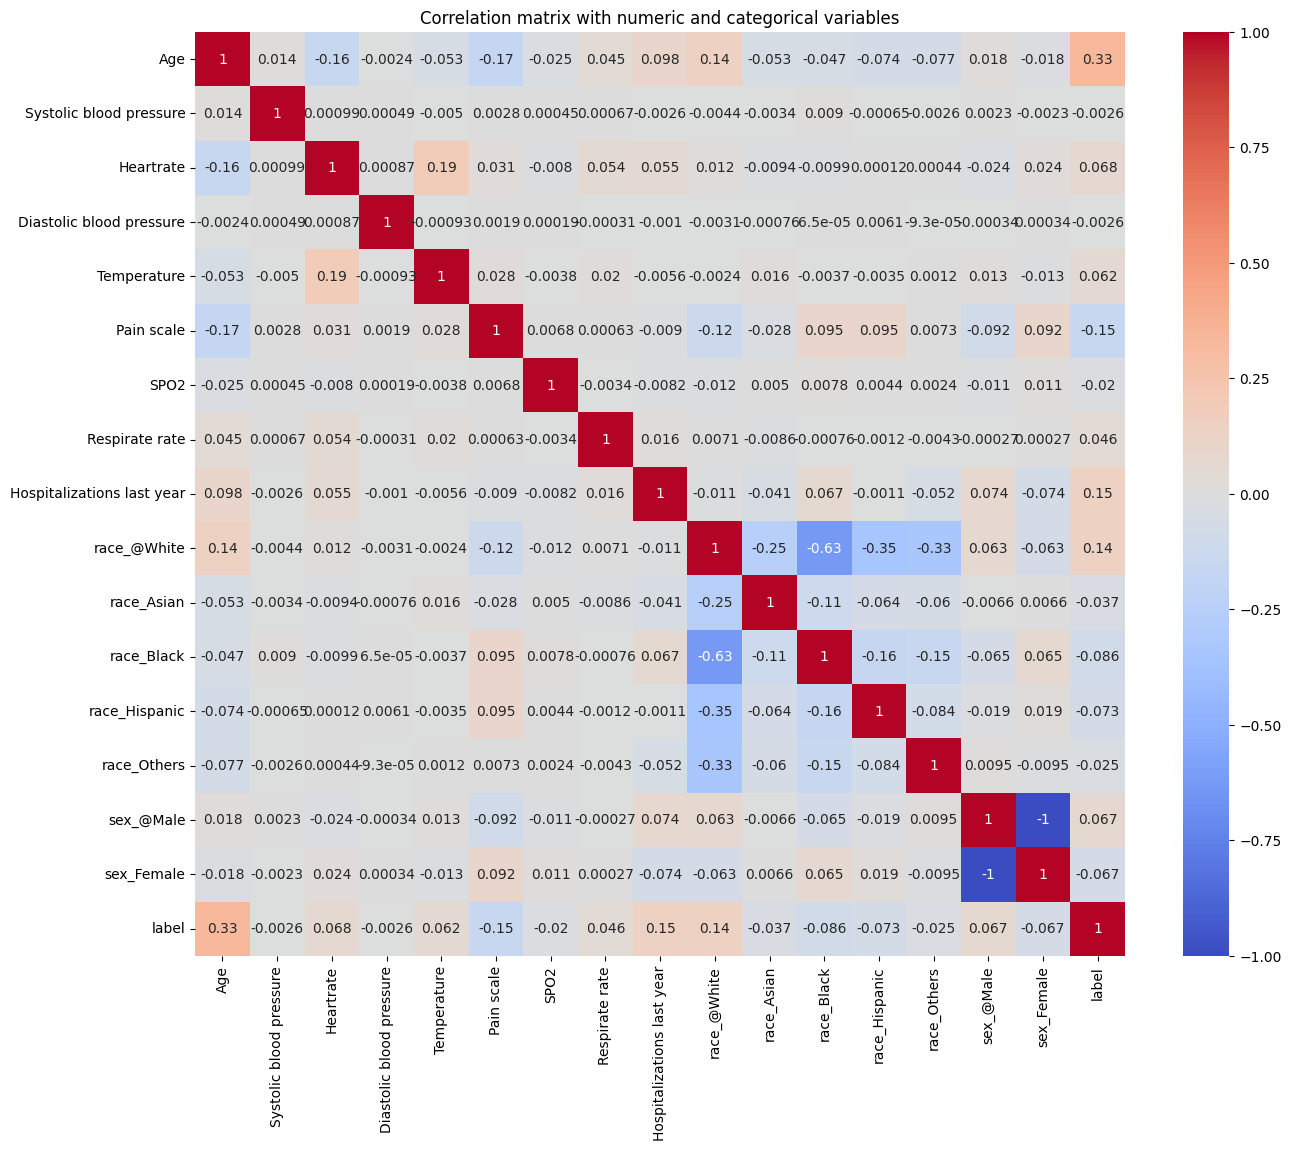

In [32]:
# Choose categorical columns
cat_cols = ['race', 'sex']

# One-hot encode categorical variables
df_cat_encoded = pd.get_dummies(dat_train[cat_cols], drop_first=False)  # keep all categories

# Combine with numeric columns
num_cols = ['Age', 'Systolic blood pressure', 'Heartrate', 'Diastolic blood pressure', 'Temperature', 'Pain scale', 'SPO2', 'Respirate rate', 'Hospitalizations last year', 'label']

df_corr = pd.concat([dat_train[num_cols], df_cat_encoded], axis=1)
cols = [c for c in df_corr.columns if c != 'label'] + ['label']
df_corr = df_corr[cols]


# Compute correlation matrix
corr_matrix = df_corr.corr()

plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", cbar=True)
plt.title("Correlation matrix with numeric and categorical variables")
plt.show()

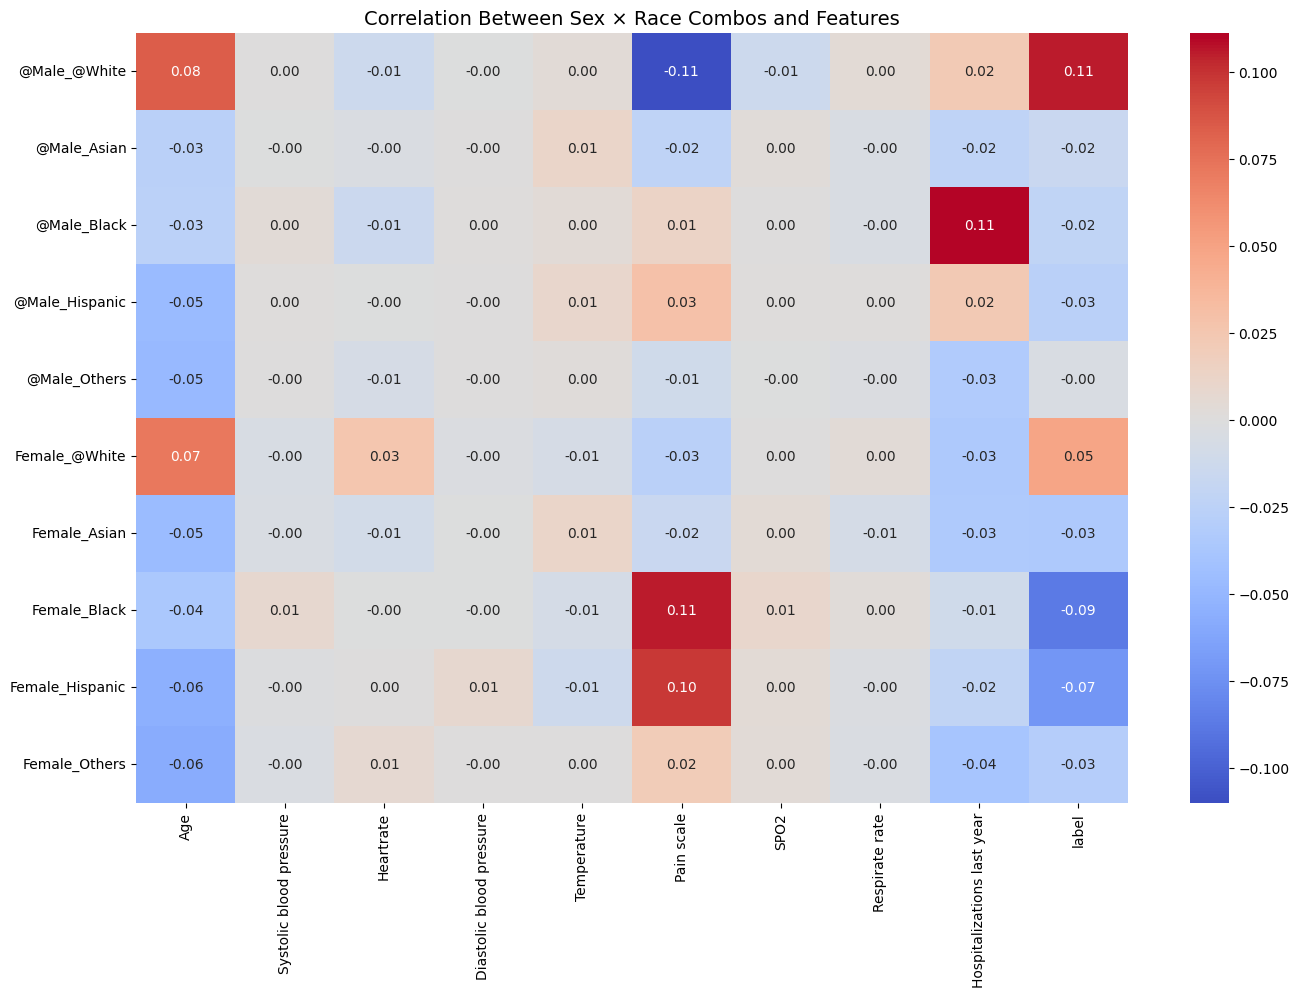

In [33]:
# Create Sex × Race combination
dat_train["Sex_Race"] = dat_train["sex"].astype(str) + "_" + dat_train["race"].astype(str)

# One-hot encode Gender_Race
gender_race_encoded = pd.get_dummies(dat_train["Sex_Race"], prefix='', prefix_sep='')

# One-hot encode other categorical variables if needed
#cat_vars = ['language', 'insurance', 'marital_status']
#cat_encoded = pd.get_dummies(cohort[cat_vars], prefix='', prefix_sep='')

# Keep numeric columns
num_cols = ['Age', 'Systolic blood pressure', 'Heartrate', 'Diastolic blood pressure', 'Temperature', 'Pain scale', 'SPO2', 'Respirate rate', 'Hospitalizations last year']


# Combine all features
df_encoded = pd.concat([gender_race_encoded, dat_train[num_cols], dat_train[['label']]], axis=1)

# Reorder so 'label' is last
cols = [c for c in df_encoded.columns if c != 'label'] + ['label']
df_encoded = df_encoded[cols]

# Compute correlation between Gender_Race and everything else
combo_cols = gender_race_encoded.columns.tolist()
corr_sub = df_encoded.corr().loc[combo_cols, df_encoded.columns.drop(combo_cols)]

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_sub, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Between Sex × Race Combos and Features", fontsize=14)
plt.show()